# E2E Latency comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_latency(filepath, warmup_steps=5):
    df = pd.read_csv(filepath)
    d = {}
    for index, row in df.iterrows():
        if row['num_objects'] not in d:
            d[row['num_objects']] = []
        d[row['num_objects']].append(row['latency'])
    avg, std = {}, {}
    for num_objects, latency in d.items():
        avg[num_objects] = pd.Series(latency[warmup_steps:]).mean()
        std[num_objects] = pd.Series(latency[warmup_steps:]).std()
    return avg, std

def get_breakdown_data(filepath, num_objects, warmup_steps=5):
    breakdown_df = pd.read_json(filepath)
    breakdown_agg = {
        "request_total_time": [],
        "token_validation_time": [],
        "history_validation_time": [],
        "policy_execution_time": [],
        "history_update_time": [],
        "resource_api_time": [],
    }
    for n in num_objects:
        d = breakdown_df[breakdown_df['history_length'] == n * 10]
        for k in breakdown_agg.keys():
            if k in d.columns:
                breakdown_agg[k].append(d.iloc[warmup_steps:][k].mean() * 1000)
    return breakdown_agg

In [3]:
def plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error = np.array(list(std_stateful.values()))  # Replace [...] with your error values for stateful_bar

    # Set up positions for bars
    bar_width = 0.25

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width/2, baseline_bar, bar_width, label='OAuth E2E Latency', color="#046586")

    # Add breakdown
    network_latency = stateful_bar - breakdown_agg['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index + bar_width / 2, network_latency, bar_width, bottom=np.zeros(len(network_latency)), label=f'StatefulAuth Network Latency', color="#b22222")
    bar2 = ax.bar(index + bar_width/2, breakdown_agg['request_total_time'], bar_width, bottom=network_latency, label='StatefulAuth Server-Side Latency', color="#f4a016")

    # Move legend above the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, shadow=True, fontsize=9)

    # Add error bars
    ax.errorbar(index - bar_width/2, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index + bar_width/2, stateful_bar, yerr=stateful_error, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth)')

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


In [4]:
def plot_breakdown(num_objects, avg_baseline, avg_stateful, breakdown_agg):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # server_latency = np.array(breakdown_agg['request_total_time'])

    # Set up positions for bars
    bar_width = 0.3
    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    # bar1 = ax.bar(index, server_latency, bar_width, label='Server-Side Latency')

    keys = ['token_validation_time', 'history_validation_time', 'policy_execution_time', 'resource_api_time', 'history_update_time']
    labels = ['Token Validation Time', 'State Validation Time', 'Policy Execution Time', 'Resource API Time', 'State Update Time']
    breakdown_data = [
        np.array(breakdown_agg[key]) for key in keys
    ]
    colors = ['#253494', '#2c7fb8', '#41b6c4', '#ffd700', '#D95319']

    bottom = None
    for i, breakdown in enumerate(breakdown_data):
        if bottom is None:
            bottom = np.zeros(len(breakdown))
        else:
            bottom += breakdown_data[i - 1]
        ax.bar(index, breakdown, bar_width, bottom=bottom, label=labels[i], color=colors[i])

    # Move legend above the plot
    ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(-0.08, 1, 1.1, 0.3), frameon=False, fontsize=9, mode="expand",)

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('Server Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 100)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('server-side_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()
    return fig, ax


In [5]:
num_objects = [1, 10, 20, 30, 40, 50]
avg_baseline, std_baseline = get_latency('data/latency/t3/latency_baseline.csv', warmup_steps=5)
avg_stateful, std_stateful = get_latency('data/latency/t3/latency_stateful.csv', warmup_steps=5)
breakdown_fp = 'data/latency/t3/latency_breakdown.txt'
breakdown_agg = get_breakdown_data(breakdown_fp, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

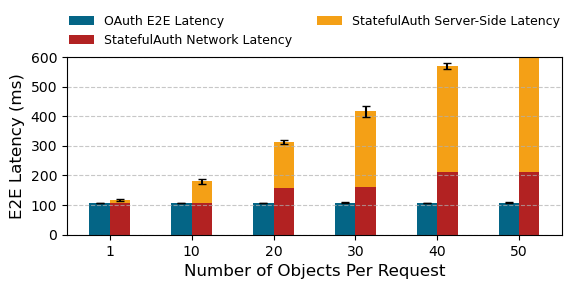

In [6]:
plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg)

### Opt 1: In-memory DB

In [7]:
avg_stateful_in_memory, std_stateful_in_memory = get_latency('data/latency/t3/latency_stateful_in_memory.csv', warmup_steps=5)
breakdown_fp_in_memory = 'data/latency/t3/latency_breakdown_in_memory.txt'
breakdown_agg_in_memory = get_breakdown_data(breakdown_fp_in_memory, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

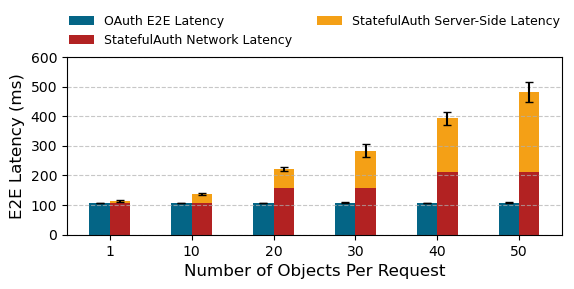

In [8]:
plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful_in_memory, std_stateful_in_memory, breakdown_agg_in_memory)

### Opt 2: c5d w/ insertion on resource API

In [9]:
avg_baseline_c5d, std_baseline_c5d = get_latency('data/latency/c5d_insert/latency_baseline.csv', warmup_steps=5)
avg_stateful_c5d, std_stateful_c5d = get_latency('data/latency/c5d_insert/latency_stateful.csv', warmup_steps=5)
breakdown_fp_c5d = 'data/latency/c5d_insert/latency_breakdown.txt'
breakdown_agg_c5d = get_breakdown_data(breakdown_fp_c5d, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

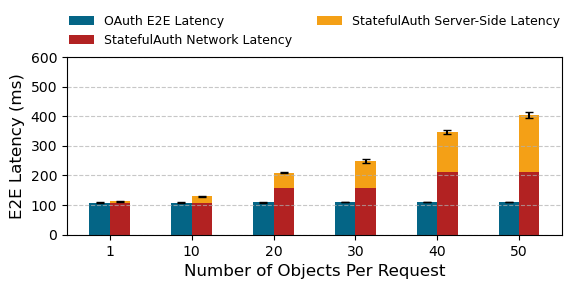

In [10]:
plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_c5d, std_stateful_c5d, breakdown_agg_c5d)

### Opt 3: Optimize serialization and deserialization of history data

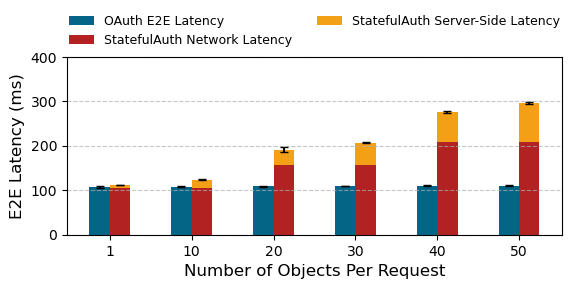

In [11]:
avg_stateful_c5d_opt, std_stateful_c5d_opt = get_latency('data/latency/c5d_insert/latency_stateful_01_30.csv', warmup_steps=5)
breakdown_fp_c5d_opt = 'data/latency/c5d_insert/latency_breakdown_01_30.txt'
breakdown_agg_c5d_opt = get_breakdown_data(breakdown_fp_c5d_opt, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_c5d_opt, std_stateful_c5d_opt, breakdown_agg_c5d_opt)
ax.set_ylim(0, 400)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

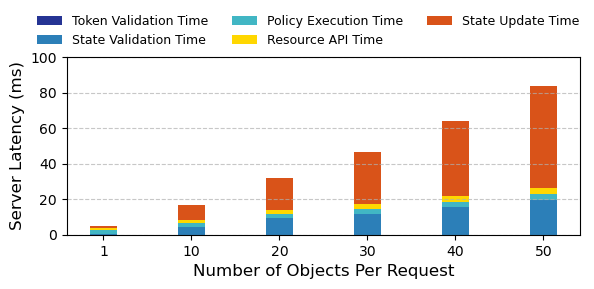

In [12]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_c5d_opt, breakdown_agg_c5d_opt)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

### Design Update: WASM State Updater

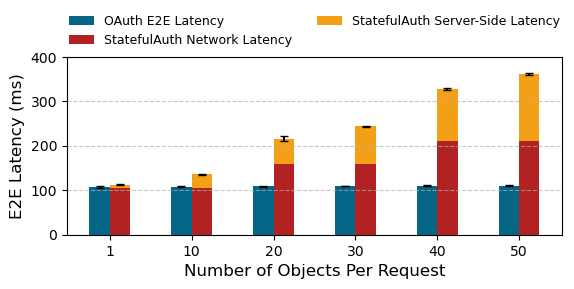

In [13]:
avg_stateful_updater, std_stateful_updater = get_latency('data/latency/c5d_insert/latency_stateful_updater.csv', warmup_steps=5)
breakdown_fp_updater = 'data/latency/c5d_insert/latency_breakdown_updater.txt'
breakdown_agg_updater = get_breakdown_data(breakdown_fp_updater, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_updater, std_stateful_updater, breakdown_agg_updater)
ax.set_ylim(0, 400)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

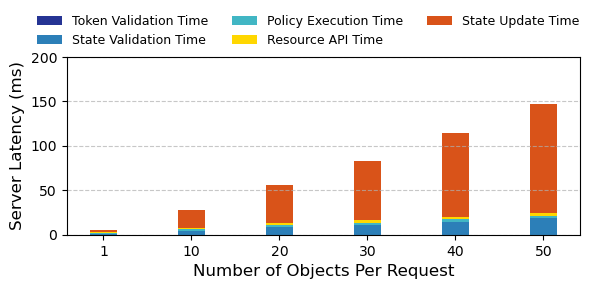

In [14]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_updater, breakdown_agg_updater)
ax.set_ylim(0, 200)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

In [15]:
for n in num_objects:
    print(f'{n} objects: {avg_stateful_updater[n]}, {avg_baseline_c5d[n]}, {avg_stateful_updater[n] / avg_baseline_c5d[n] * 100 - 100:.2f}%')

1 objects: 112.75494575500488, 108.06414604187012, 4.34%
10 objects: 135.84760665893555, 108.00156593322754, 25.78%
20 objects: 216.41192436218262, 109.20148849487305, 98.18%
30 objects: 244.07084465026855, 109.65420722961426, 122.58%
40 objects: 327.48555183410645, 110.47202110290527, 196.44%
50 objects: 361.42147064208984, 110.45014381408691, 227.23%


In [16]:
for i, n in enumerate(num_objects):
    history_validation_portion = breakdown_agg_updater["history_validation_time"][i] / breakdown_agg_updater["request_total_time"][i] * 100
    history_update_portion = breakdown_agg_updater["history_update_time"][i] / breakdown_agg_updater["request_total_time"][i] * 100
    print(f'{n} objects: {history_validation_portion:.2f}% {history_update_portion:.2f}%')

1 objects: 7.68% 31.70%
10 objects: 12.92% 69.55%
20 objects: 14.68% 74.18%
30 objects: 12.96% 78.42%
40 objects: 12.67% 80.13%
50 objects: 12.30% 81.38%


## Conclusions
1. Extra latency on server grows linearly with the number of objects.
2. Extra latency on server VERY dependent (actually linearly) on DB operations.
3. We can optimize it by running multiple threads, which a real server will also do, just some engineering efforts.
4. But the first point still holds true.

### Opt 4: Loop inside Wasm

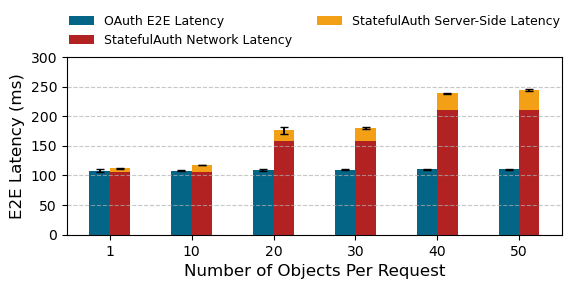

In [23]:
avg_stateful_wasm_loop, std_stateful_wasm_loop = get_latency('data/latency/c5d_insert/latency_stateful_05_13_wasm_loop.csv', warmup_steps=5)
breakdown_fp_wasm_loop = 'data/latency/c5d_insert/latency_breakdown_05_13_wasm_loop.txt'
breakdown_agg_wasm_loop = get_breakdown_data(breakdown_fp_updater, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_wasm_loop, std_stateful_wasm_loop, breakdown_agg_wasm_loop)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

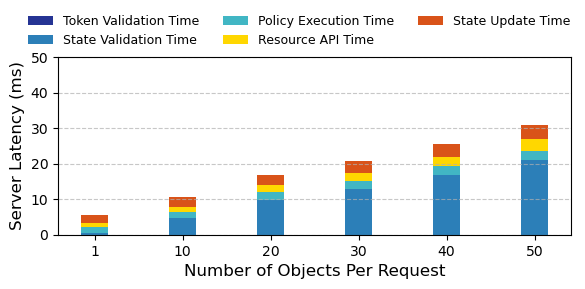

In [24]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_wasm_loop, breakdown_agg_wasm_loop)
ax.set_ylim(0, 50)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

In [25]:
breakdown_agg_wasm_loop

{'request_total_time': [6.914443969726041,
  12.200527191161562,
  18.748826980590284,
  22.92742729186968,
  28.122596740722084,
  33.69195938110305],
 'token_validation_time': [0.016260147094726562,
  0.0164794921875,
  0.01661300659179687,
  0.016565322875976562,
  0.017070770263671875,
  0.016765594482421875],
 'history_validation_time': [0.5993747711175601,
  4.57002639770464,
  9.845523834228121,
  12.808876037597162,
  16.746587753295323,
  21.05593681335408],
 'policy_execution_time': [1.6348552703852002,
  1.8357276916499605,
  2.11264610290472,
  2.24044799804648,
  2.4416160583492,
  2.6166534423823204],
 'history_update_time': [2.2983360290522405,
  2.62854576110792,
  2.8726387023920408,
  3.2540321350092802,
  3.5246849060052803,
  3.8576698303216803],
 'resource_api_time': [1.0105228424067199,
  1.4991855621333203,
  1.9516754150385203,
  2.3367500305171203,
  2.7794456481929197,
  3.2007503509516395]}

In [26]:
for n in num_objects:
    print(f'{n} objects: {avg_stateful_wasm_loop[n]}, {avg_baseline_c5d[n]}, {avg_stateful_wasm_loop[n] / avg_baseline_c5d[n] * 100 - 100:.2f}%')

1 objects: 112.37398147583008, 108.06414604187012, 3.99%
10 objects: 117.69283294677734, 108.00156593322754, 8.97%
20 objects: 176.50672912597656, 109.20148849487305, 61.63%
30 objects: 180.7587718963623, 109.65420722961426, 64.84%
40 objects: 238.56786727905273, 110.47202110290527, 115.95%
50 objects: 244.3016242980957, 110.45014381408691, 121.19%


In [27]:
for i, n in enumerate(num_objects):
    history_validation_portion = breakdown_agg_wasm_loop["history_validation_time"][i] / breakdown_agg_wasm_loop["request_total_time"][i] * 100
    history_update_portion = breakdown_agg_wasm_loop["history_update_time"][i] / breakdown_agg_wasm_loop["request_total_time"][i] * 100
    print(f'{n} objects: {history_validation_portion:.2f}% {history_update_portion:.2f}%')

1 objects: 8.67% 33.24%
10 objects: 37.46% 21.54%
20 objects: 52.51% 15.32%
30 objects: 55.87% 14.19%
40 objects: 59.55% 12.53%
50 objects: 62.50% 11.45%


# Throughput Comparison

In [31]:
import os
def get_tputs(folderpath, model='stateful'):
    tputs = {}
    for n_process in [1, 2, 4, 8, 16, 32, 64, 128]:
        files = [f for f in os.listdir(folderpath) if f.startswith(f'tput_{model}_{n_process}_')]
        if len(files) == 0:
            break
        global_tput = 0
        for f in files:
            with open(os.path.join(folderpath, f), 'r') as fp:
                df = pd.read_csv(fp)
                local_tput = df['tput'].median()
                global_tput += local_tput
        tputs[n_process] = global_tput
    return tputs

In [38]:
def plot_tputs(baseline_tputs, stateful_tputs, n_columns=4):

    # Sample data (replace this with your actual data)
    # n = min(len(baseline_tputs), len(stateful_tputs))
    xs = [2 ** i for i in range(0, n_columns)]
    baseline_tputs = [baseline_tputs[x] for x in xs]
    stateful_tputs = [stateful_tputs[x] for x in xs]

    # Set up positions for bars
    bar_width = 0.3  # Adjust the bar width for a two-bar comparison
    index = np.arange(len(xs))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # alpha=0.95
    bar1 = ax.bar(index - bar_width/2, baseline_tputs, bar_width, label='OAuth', color='#046586')
    bar2 = ax.bar(index + bar_width/2, stateful_tputs, bar_width, label='StatefulAuth', color='#B22222')

    ax.set_xlabel('Number of Processes', fontsize=12)
    ax.set_ylabel('Throughput (req/s)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(xs, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
    # Move legend above the plot
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False)

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 200)  # Set y-axis limit for better visualization

    # Add data labels at the middle of each bar
    for bars in [bar1, bar2]:
        for bar in bars:
            if bar.get_height() != 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                        f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10, color='black')

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/throughput_comparison.png', dpi=300)

    # Show the plot
    plt.show()


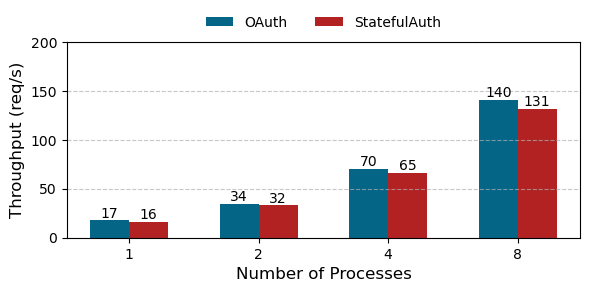

In [39]:
baseline_tputs = get_tputs('data/tput/baseline_insert/1_obj', model='baseline')
stateful_tputs = get_tputs('data/tput/stateful_insert/1_obj', model='stateful')
plot_tputs(baseline_tputs, stateful_tputs, n_columns=4)

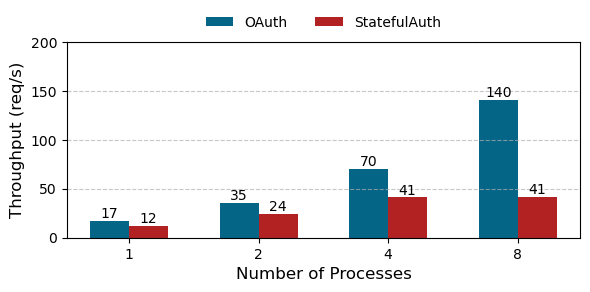

In [40]:
baseline_tputs_10_objs = get_tputs('data/tput/baseline_insert/10_obj/', model='baseline')
stateful_tputs_10_objs = get_tputs('data/tput/stateful_insert/10_obj/', model='stateful')
plot_tputs(baseline_tputs_10_objs, stateful_tputs_10_objs, n_columns=4)

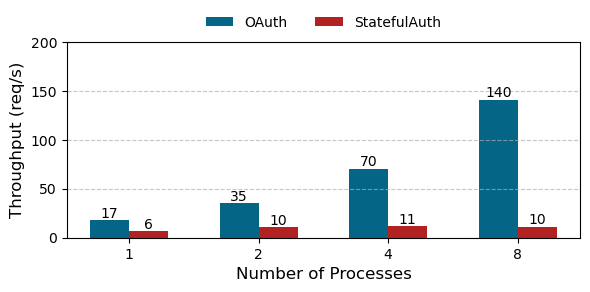

In [41]:
baseline_tputs_30_objs = get_tputs('data/tput/baseline_insert/30_obj/', model='baseline')
stateful_tputs_30_objs = get_tputs('data/tput/stateful_insert/30_obj/', model='stateful')
plot_tputs(baseline_tputs_30_objs, stateful_tputs_30_objs, n_columns=4)

### Opt: Optimize serialization and deserialization of history

In [46]:
stateful_tputs_opt

{1: 16.56669342710486,
 2: 33.09827483019211,
 4: 66.02496199050354,
 8: 133.11292808074788,
 16: 183.5136111936594,
 32: 182.73377745347545}

In [47]:
baseline_tputs

{1: 17.685891468103584,
 2: 34.96588165405399,
 4: 70.30658627786363,
 8: 140.46465360060225,
 16: 278.2297922175132,
 32: 524.374617953686,
 64: 536.1260866278577,
 128: 535.6548850524525}

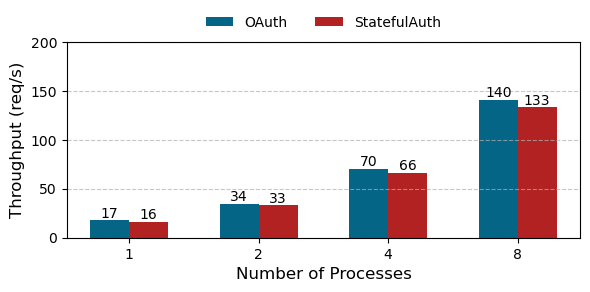

In [42]:
stateful_tputs_opt = get_tputs('data/tput/stateful_01_30/1_obj', model='stateful')
plot_tputs(baseline_tputs, stateful_tputs_opt, n_columns=4)

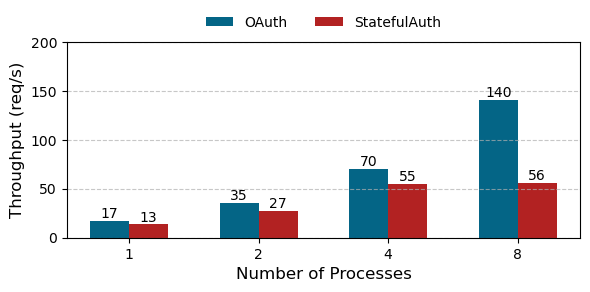

In [44]:
stateful_tputs_10_objs_opt = get_tputs('data/tput/stateful_01_30/10_obj/', model='stateful')
plot_tputs(baseline_tputs_10_objs, stateful_tputs_10_objs_opt, n_columns=4)

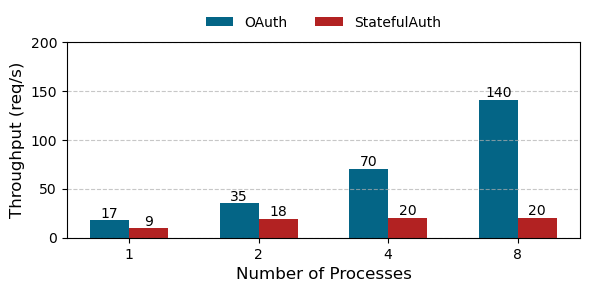

In [45]:
stateful_tputs_30_objs_opt = get_tputs('data/tput/stateful_01_30/30_obj/', model='stateful')
plot_tputs(baseline_tputs_30_objs, stateful_tputs_30_objs_opt, n_columns=4)

# Performance Breakdown

In [10]:
import json
logs = json.load(open('logs_2024-01-22_07:34:05.txt', 'r'))
d = {}  # {(path, method, policy_succeeds): [{token_validation_time: .., history_validation_time, policy_execution_time: .., history_update_time: ..}]}
for l in logs:
    if not l['request_path'].startswith('/api/events/'):
        continue
    if l['request_path'] != '/api/events':
        l['request_path'] = '/api/events/<event_id>'
    k = (l['request_path'], l['request_method'], l['policy_succeeds'])
    if k not in d:
        d[k] = []
    d[k].append({
        'token_validation_time': l['token_validation_time'] * 1000,
        'history_validation_time': l['history_validation_time'] * 1000,
        'policy_execution_time': l['policy_execution_time'] * 1000,
        'history_update_time': l['history_update_time'] * 1000,
    })

In [16]:
def print_statistics(s, lst):
    from statistics import mean, median, stdev
    if mean(lst) > 0:
        print(s, ':', "%.3f" % mean(lst), "%.3f" % median(lst), "%.3f" % stdev(lst), "%.3f" % (stdev(lst) / mean(lst)))
    else:
        print(s, ':', "%.3f" % mean(lst), "%.3f" % median(lst), "%.3f" % stdev(lst))


In [17]:
for k, v in d.items():
    print('-' * 20)
    print(k)
    print_statistics('token_validation_time', [i['token_validation_time'] for i in v])
    print_statistics('history_validation_time', [i['history_validation_time'] for i in v])
    print_statistics('policy_execution_time', [i['policy_execution_time'] for i in v])
    print_statistics('history_update_time', [i['history_update_time'] for i in v])

--------------------
('/api/events/<event_id>', 'GET', False)
token_validation_time : 0.028 0.028 0.001 0.027
history_validation_time : 0.728 0.714 0.051 0.070
policy_execution_time : 1.393 1.395 0.049 0.035
history_update_time : 0.000 0.000 0.000
--------------------
('/api/events/<event_id>', 'GET', True)
token_validation_time : 0.029 0.028 0.005 0.167
history_validation_time : 0.855 0.854 0.018 0.021
policy_execution_time : 1.371 1.356 0.032 0.023
history_update_time : 5.553 5.517 0.489 0.088
--------------------
('/api/events/<event_id>', 'POST', True)
token_validation_time : 0.028 0.028 0.000 0.012
history_validation_time : 0.926 0.926 0.019 0.020
policy_execution_time : 1.392 1.392 0.003 0.002
history_update_time : 5.189 5.189 0.470 0.091
--------------------
('/api/events/<event_id>', 'POST', False)
token_validation_time : 0.030 0.030 0.003 0.084
history_validation_time : 0.766 0.776 0.027 0.035
policy_execution_time : 1.413 1.400 0.054 0.038
history_update_time : 0.000 0.000 0.